# Spam URL classifier

In this notebook we will create a model capable of classifying URLs to check if they are spam or ham.

In [343]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score
import seaborn as sns
from pickle import dump

In [344]:
URL = 'https://raw.githubusercontent.com/4GeeksAcademy/NLP-project-tutorial/main/url_spam.csv'
raw_df = pd.read_csv(URL)

## Data overview

In [345]:
raw_df

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,True
1,https://www.hvper.com/,True
2,https://briefingday.com/m/v4n3i4f3,True
3,https://briefingday.com/n/20200618/m#commentform,False
4,https://briefingday.com/fan,True
...,...,...
2994,https://www.smartcitiesworld.net/news/news/dee...,False
2995,https://www.youtube.com/watch,True
2996,https://techcrunch.com/2019/07/04/an-optimisti...,False
2997,https://www.technologyreview.com/2019/12/20/13...,False


In [346]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2999 entries, 0 to 2998
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   url      2999 non-null   object
 1   is_spam  2999 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 26.5+ KB


In [347]:
spam_percent = raw_df.is_spam.mean()
print(f'Percentage of spam urls: {100*spam_percent:.2f}%')

Percentage of spam urls: 23.21%


In [348]:
n_duplicated = raw_df.duplicated().sum()
print(f'There are {n_duplicated} duplicated urls.')

There are 630 duplicated urls.


### Overview analysis

Before doing anything, we will need to eliminate the duplicates. Apart from that the data is pretty clean.

In [349]:
df = raw_df.copy()
df.drop_duplicates(inplace=True)
n_duplicated = df.duplicated().sum()
print(f'There are {n_duplicated} duplicated urls.')

There are 0 duplicated urls.


## Data processing

**Notes:**
- Usually the `is_spam` column would need to be converted to a numerical variable, but in python the bool class is a sub class of int (you can check by executing `isinstance(True, int)`) so that step is not necessary.
- Nowadays, many spam websites try to mimic popular URLs by using very similar names but with some deceiving spellings, for this reason it is important to not normalize or lematize the URLs as we would do with other text data.

In [350]:
df['tokens'] = df.url.str.split(r':\/\/|\/|\.')
df

,url,is_spam,tokens
0,https://briefingday.us8.list-manage.com/unsubs...,True,"[https, briefingday, us8, list-manage, com, un..."
1,https://www.hvper.com/,True,"[https, www, hvper, com, ]"
2,https://briefingday.com/m/v4n3i4f3,True,"[https, briefingday, com, m, v4n3i4f3]"
3,https://briefingday.com/n/20200618/m#commentform,False,"[https, briefingday, com, n, 20200618, m#comme..."
4,https://briefingday.com/fan,True,"[https, briefingday, com, fan]"
...,...,...,...
2993,https://www.theverge.com/2020/6/29/21306889/di...,False,"[https, www, theverge, com, 2020, 6, 29, 21306..."
2994,https://www.smartcitiesworld.net/news/news/dee...,False,"[https, www, smartcitiesworld, net, news, news..."
2996,https://techcrunch.com/2019/07/04/an-optimisti...,False,"[https, techcrunch, com, 2019, 07, 04, an-opti..."
2997,https://www.technologyreview.com/2019/12/20/13...,False,"[https, www, technologyreview, com, 2019, 12, ..."


### Figure 1

her we can see a wordcloud graph showing the most common words in our URLs (the bigger, the more often we see each word)

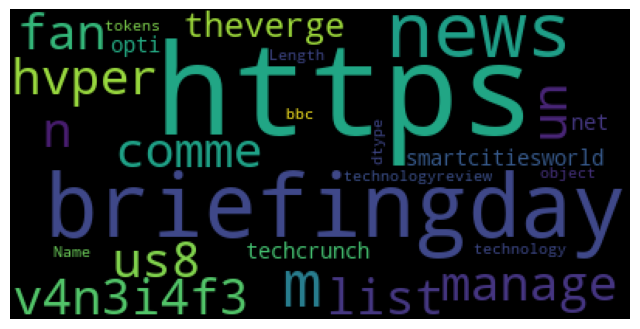

In [351]:
wordcloud = WordCloud(random_state=42).generate(str(df.tokens))

fig = plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Vectorization

Since we have an unbalanced dataset, and since we have words that repeat very often without adding information we can use a TF-IDF vectorizer with a `max_df=0.8`, that measures the importance of words repeated a lot along our dataset. This should counterweigh a bit the presence of `https` on every URL. Also since many features probably will be negligible, I setted `max_features=1000`.

In [352]:
vectorizer = TfidfVectorizer(max_features=1000, max_df=0.8)
tokens = df.tokens.apply(lambda x: ' '.join(x))

x = vectorizer.fit_transform(tokens).toarray()
y = df.is_spam
x


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(2369, 1000))

## Model creation

We choose to use a SVM model.

In [353]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, random_state=42, test_size=0.2)

In [354]:
model = SVC(random_state=42, kernel='linear',C=8)
model.fit(xtrain, ytrain)

,C,8
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [355]:
params = {
    'C':[0.5,1,5,8,10],
    'kernel':['linear','sigmoid','rbf'],
    
}
grid = GridSearchCV(model, params, scoring='recall', n_jobs=-1)
grid.fit(xtrain, ytrain)
tunned_model = grid.best_estimator_
tunned_model

,C,10
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


recall score: 0.74
accuracy score: 0.95


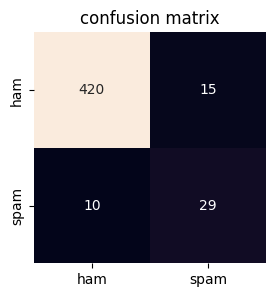

In [356]:
ypredic = tunned_model.predict(xtest)
res = (ytest, ypredic)

plt.figure(figsize=(3,3))
plt.title('confusion matrix')
sns.heatmap(
    confusion_matrix(*res),
    annot=True, fmt='',
    cbar=False,
    yticklabels=['ham','spam'],
    xticklabels=['ham','spam']
)

print(f'recall score: {recall_score(*res):.2f}')
print(f'accuracy score: {accuracy_score(*res):.2f}')

### Model conclusions

- With this we can confirm that avoiding lemmatization and normalization was a good choice. Although it was not shown in this notebook, I checked at the results using normalization and lematization for the same data and the recall score dropped to `0.5`, which is too low for an spam classifier.

- Our final recall score is `0.74` which is somewhat low for an spam classifier but it clearly works. Also, it is a good start point before creating new models or applying resampling techniques to improve our evaluation metrics.

In [357]:
dump(model, open('../models/svm_lineal_C_8_42.pkl', 'wb'))